To-do:
- Make sure all libraries in for 3D -> 1D pharmacophore graph
- As in matrix calculations
- Network X

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
from rdkit.Chem.Draw import MolsToGridImage
from pharmacophore import Pharmacophore, Draw, View
from chembl_structure_pipeline import standardize_mol as chembl_standardizer
from GraphTsetlinMachine.graphs import Graphs

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from netgraph import Graph



[15:42:45] Initializing Normalizer


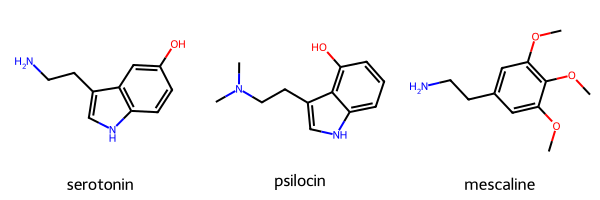

In [3]:
molecules = {"serotonin": "C1=CC2=C(C=C1O)C(=CN2)CCN",
             "psilocin": "CN(C)CCc1c[nH]c2cccc(O)c12",
             "mescaline": "O(c1cc(cc(OC)c1OC)CCN)C"}

mol_smi = [smi for smi in molecules.values()]
mol_name = [name for name in molecules.keys()]
mols = [Chem.MolFromSmiles(smi) for smi in mol_smi]

MolsToGridImage(mols=mols, legends=mol_name)

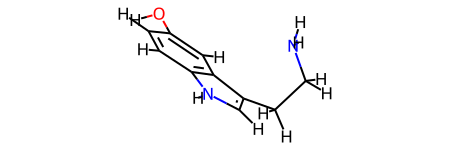

In [4]:
mols = [Chem.AddHs(mol) for mol in mols]

ps = AllChem.ETKDGv3()
ps.randomSeed = 1
for mol in mols:
    AllChem.EmbedMolecule(mol, ps)
    
mols[0]

In [5]:
aligned = []

for mol in mols:
    mol_aligned = rdMolAlign.GetO3A(mol, mols[0])
    aligned.append(mol_aligned.Align())

In [6]:
# conformations stored as sdf files
# this is step 1
for mol, name in zip(mols, mol_name):
    w = Chem.SDWriter(f"test_data/{name}.sdf")
    w.write(mol)
    w.close()

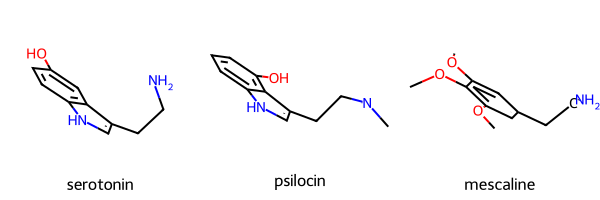

In [7]:
mols_noH = [Chem.RemoveHs(mol) for mol in mols]
MolsToGridImage(mols=mols_noH, legends=mol_name)

In [21]:
# test default and rdkit pharmacophore features: "default" and "rdkit"
PHARM_FEATURES = "default"
pharm = Pharmacophore(features=PHARM_FEATURES)

# can test this also -- presence/absence of pharmacophore features
# simply binarized
df = pharm.to_df(mols_noH, mol_name=mol_name)
df
list(eval(pharm.feature_types().split("\n")[1]))

['Donor', 'Acceptor', 'Aromatic', 'Hydrophobe']

In [9]:
def mol_from_smiles(smiles, *args, standardizer=chembl_standardizer) -> Chem.Mol:
    """
    Convert a SMILES string to an RDKit Mol object

    :param smiles: SMILES string. Required.
    :param standardizer: function to standardize the molecule. Defaults to ChEMBL standardizer. Use None to skip.
    :return: RDKit Mol object
    """
    mol = Chem.MolFromSmiles(str(smiles))
    if not mol:
        return None
    if standardizer is None:
        return mol
    return standardizer(mol, check_exclusion=True, sanitize=True)

In [22]:


def condense_features(pharma):
    pharma_arr = np.array(pharma, dtype=object)
    condensed_pharma = []
    atom_index = pharma_arr[:, 1]
    grouped = pd.Series(range(len(atom_index))).groupby(atom_index, sort=False).apply(list).tolist()
        
    for group in grouped:
        features = pharma_arr[group, 0]
        x_coords = pharma_arr[group, 2].astype(float)[0]
        y_coords = pharma_arr[group, 3].astype(float)[0]
        z_coords = pharma_arr[group, 4].astype(float)[0]
        condensed_pharma.append([features, atom_index[group[0]], x_coords, y_coords, z_coords])
    
    return condensed_pharma

def distance_matrix_pharma(condensed_pharma):
    cond_pharma_arr = np.array(condensed_pharma, dtype=object)
    coords = cond_pharma_arr[:, 2:5].astype(float)
    dist_matrix = distance_matrix(coords, coords)
    return dist_matrix

def smiles_to_1DPharma(smiles, pharm_features="default", random_seeds=[1,2,3,4,5]):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    pharm = Pharmacophore(features=pharm_features)
    distance_matrices = []
    for seed in random_seeds:
        ps = AllChem.ETKDGv3()
        ps.randomSeed = seed
        AllChem.EmbedMolecule(mol, ps)
        mol_noH = Chem.RemoveHs(mol)
        pharma = pharm.calc_pharm(mol_noH)
        if len(pharma) > 0:
            condensed_pharma = condense_features(pharma)
            distance_matrices.append(distance_matrix_pharma(condensed_pharma))
            # feature details, edge lengths averaged over conformations and rounded to nearest whole number
            return np.array(condensed_pharma, dtype=object)[:,0:2], np.round(np.average(distance_matrices, axis=0), 0).astype(int)
        else:
            return None

def dataset_to_1DPharmaCAIRGraphs(dataset_path, smiles_col="SMILES", pharm_features="default", random_seeds=[1,2,3,4,5]):
    df = pd.read_csv(dataset_path)
    df['mol'] = df[smiles_col].apply(mol_from_smiles)
    df.dropna(subset=['mol'], inplace=True)
    df['pharmacophore'] = df['SMILES'].apply(smiles_to_1DPharma, pharm_features=pharm_features, random_seeds=random_seeds)
    df.dropna(subset=['pharmacophore'], inplace=True)
    pharma_list = df['pharmacophore'].tolist()
    
    n_mols = len(pharma_list)
    pharm_gen = Pharmacophore(features=pharm_features)
    features = list(eval(pharm_gen.feature_types().split("\n")[1]))
    print("Pharmacophore features used:", features)
    
    cair_graphs = Graphs(
        n_mols,
        symbols = features,
        hypervector_size = 10000,
        hypervector_bits = 2,
        double_hashing=False
    )
    
    for mol_indx, pharamcophore in enumerate(pharma_list):
        condensed_pharma, _ = pharamcophore
        cair_graphs.set_number_of_graph_nodes(mol_indx, len(condensed_pharma))
        
    cair_graphs.prepare_node_configuration()
    for mol_indx, pharamcophore in enumerate(pharma_list):
        condensed_pharma, _ = pharamcophore
        n_edges = len(condensed_pharma) - 1
        
        for feature_point_indx in range(len(condensed_pharma)):
            cair_graphs.add_graph_node(
                mol_indx,
                feature_point_indx,
                n_edges
            )
    
    cair_graphs.prepare_edge_configuration()
    
    for mol_indx, pharamcophore in enumerate(pharma_list):
        print("mol index:", mol_indx)
        condensed_pharma, dist_matrix = pharamcophore
        for i in range(len(dist_matrix)):
            for j in range(len(dist_matrix)):
                if i != j:
                    edge_length = dist_matrix[i][j]
                    cair_graphs.add_graph_node_edge(
                        mol_indx,
                        i,
                        j,
                        edge_length
                    )
            
            print("Mol Index:", mol_indx, "Feature Point Index:", i)
            print("Features:", condensed_pharma[i][0])
               
            for feature_indx, feature in enumerate(condensed_pharma[i][0]):    
                cair_graphs.add_graph_node_property(
                    mol_indx,
                    i,
                    feature
                )          
    cair_graphs.encode()
    return cair_graphs, df
    


# visualization
def pharma1D_nx_graph(condensed_pharma, dist_matrix):
    G = nx.Graph()
    for feature_point_indx in range(len(condensed_pharma)):
        feature_dict = {}
        for feature_indx, feature in enumerate(condensed_pharma[feature_point_indx][0]):
            feature_dict[feature_indx] = feature        
        G.add_nodes_from([(feature_point_indx, feature_dict)])
    for i in range(len(dist_matrix)):
        for j in range(i+1, len(dist_matrix)):
            G.add_edge(i, j, weight=dist_matrix[i][j])
    return G
    
PHARM_FEATURES = "default"

X_graph, clean_df = dataset_to_1DPharmaCAIRGraphs("./datasets/opioids/CYP2D6_cutoff6.csv", pharm_features=PHARM_FEATURES)

# nx_graph = pharma_nx_graph(condensed_pharma, dist_matrix)
# print(nx_graph.nodes(data=True))
# print(nx_graph.edges(data=True))

# # color network by feature type
# nx.draw(nx_graph, with_labels=True, )

[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharger
[16:00:04] Running Normalizer
[16:00:04] Running Uncharg

Pharmacophore features used: ['Donor', 'Acceptor', 'Aromatic', 'Hydrophobe']
mol index: 0
Mol Index: 0 Feature Point Index: 0
Features: ['Donor']
Mol Index: 0 Feature Point Index: 1
Features: ['Donor']
Mol Index: 0 Feature Point Index: 2
Features: ['Acceptor']
Mol Index: 0 Feature Point Index: 3
Features: ['Acceptor']
Mol Index: 0 Feature Point Index: 4
Features: ['Acceptor']
Mol Index: 0 Feature Point Index: 5
Features: ['Acceptor']
Mol Index: 0 Feature Point Index: 6
Features: ['Aromatic']
Mol Index: 0 Feature Point Index: 7
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 8
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 9
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 10
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 11
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 12
Features: ['Hydrophobe']
Mol Index: 0 Feature Point Index: 13
Features: ['Hydrophobe']
mol index: 1
Mol Index: 1 Feature Point Index: 0
Features: ['Acceptor']


In [23]:
v=View()
pharma = []
for mol in mols_noH:
    pharma.append(pharm.calc_pharm(mol))
v.view(mols_noH, pharma, labels=True)

# next is networkx of flat pharmacophore

interactive(children=(Dropdown(description='Select:', options=(('Molecule 1', 0), ('Molecule 2', 1), ('Molecul…

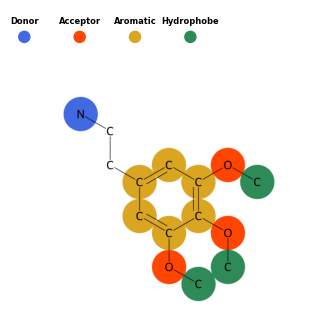

In [20]:
draw = Draw()
draw.draw_pharm(mols_noH[2])